#### Demo 04: View water column data

## Introduction

This Jupyter Notebook contains an introduction to viewing water column data using Ping.

## Here you will learn

- 

## Short version

At the end of the notebook you will find the important parts of this notebook, compiled into a single cell


## ---

### First: Import the necessary modules

In [6]:
%matplotlib widget
import os
from tqdm.auto import tqdm

import numpy as np

from matplotlib import pyplot as plt
from themachinethatgoesping.echosounders import index_functions
from themachinethatgoesping.echosounders import kongsbergall
import themachinethatgoesping as Ping


In [17]:
# define a list of folder(s) to search for raw data files
folders = []

#folders = ["../unittest_data/"]

folders.append("/home/data/turbeams/TURBEAMS_data_crunshing/campaigns/05_TURBEAMS_April_2023/Stations")
folders.append("/home/data/turbeams/TURBEAMS_data_crunshing/campaigns/05_TURBEAMS_April_2023/Transect")
folders = [
   '/home/data/test_data/alex_yolla/'
]

#folders = ["../unittest_data/"]

# find all .all/.wcd files and cache file positions
files = index_functions.find_files(folders, [".all","wcd"])
cache_files = index_functions.get_cache_file_paths(files)

# open all files and index
fm = kongsbergall.KongsbergAllFileHandler(files,cache_files)    
Ping.pingprocessing.core.clear_memory()

Found 216 files
indexing files ⢀ 99% :00s<00m:00s] [Found: 207091 datagrams in 216 files (4594MB)]                                               
Initializing datagramdata interface ⠈ 0% :00s<00m:00s]           
Initializing ping interface ⠂ 99% :01s<00m:00s] [Done]                                              


## Filter pings
Pings must contain watercolumn amplitudes to view watercolumn data


In [18]:
filtered_pings = Ping.pingprocessing.filter_pings.by_features(fm.get_pings(), ['watercolumn.av', 'bottom.xyz'], progress = True)

grouped_pings = Ping.pingprocessing.group_pings.dual_head(filtered_pings, progress = True)
len(grouped_pings)

33637

In [14]:
del fm 
Ping.pingprocessing.core.clear_memory()

## Plot pings

In [19]:
pss = Ping.echosounders.pingtools.PingSampleSelector()
pss.select_beam_range_by_angles(-90,90,1)

plotter = Ping.pingprocessing.widgets.WCIViewer(grouped_pings[::], ping_sample_selector = pss)

In [21]:
echodata = Ping.pingprocessing.watercolumn.echograms.EchoData.from_pings(filtered_pings)

  1%|          | 235/33637 [00:01<02:22, 234.67it/s]

In [ ]:
echodata.

  0%|          | 0/8 [00:00<?, ?it/s]

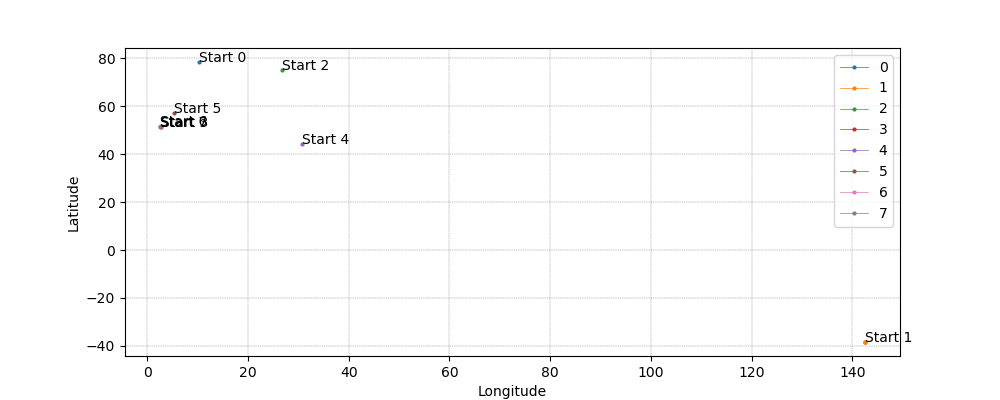

Output()

In [11]:
import matplotlib.pyplot as plt
import types
import datetime as dt
import ipywidgets

plt.ioff()
fig_nav, ax_nav = Ping.pingprocessing.core.create_figure("navigation")
fig_nav.set_size_inches((10,4))
ax_nav.set_xlabel('Longitude')
ax_nav.set_ylabel('Latitude')
ax_nav.grid(color='grey', linestyle='--', linewidth=0.3)

for label,pings in tqdm(Ping.pingprocessing.split_pings.by_time_difference(filtered_pings[::10],1000).items()):
    overview = Ping.pingprocessing.overview.get_ping_overview(pings, progress = True)
    
    overview.plot_navigation(
        ax=ax_nav,
        label=str(label),
        annotate=True,
        max_points=10000)

ax_nav.legend()

# Draw the figure for the first time
fig_nav.canvas.draw()

# Store the background
plotter.nav_background = fig_nav.canvas.copy_from_bbox(ax_nav.bbox)

plotter.nav_x=None
plotter.nav_y=None
plotter.scatter = None
plotter.draw_scatter = None

def show_pos(self, animated=True):
    ping = self.imagebuilder.pings[self.w_index.value]
    
    if not isinstance(ping,Ping.echosounders.filetemplates.I_Ping):
        ping = next(iter(ping.values()))

    geo = ping.get_geolocation()
    
    # Update scatter plot data
    self.nav_x  = geo.longitude
    self.nav_y  = geo.latitude
            
    # Restore the background
    fig_nav.canvas.restore_region(plotter.nav_background)
    fig_nav.canvas.flush_events()
    
    if self.draw_scatter is not None:
        self.draw_scatter.remove()
        self.draw_scatter = None
        fig_nav.canvas.flush_events()
        
    if self.scatter is None:
        self.scatter = ax_nav.scatter(self.nav_x,self.nav_y,s=50,color='Red', zorder=100, animated = True)
    else:
        self.scatter.set_offsets((self.nav_x,self.nav_y))
    
    # Redraw just the points
    ax_nav.draw_artist(self.scatter)
    
    # Blit the figure
    #fig_nav.canvas.flush_events()
    fig_nav.canvas.blit(ax_nav.bbox)

output = ipywidgets.Output()

skip_event=False
def draw_event(event):
    global skip_event
    if skip_event:
        return
    if fig_nav.canvas.manager is None:
        return
        
    with output:
        skip_event = True
        if plotter.draw_scatter is not None:
            plotter.draw_scatter.remove()
            
        plotter.draw_scatter = ax_nav.scatter(plotter.nav_x,plotter.nav_y,s=50,color='Red', zorder=100, animated = False)

        fig_nav.canvas.draw()
        skip_event = False
        fig_nav.canvas.flush_events()

def resize_event(event):
    global skip_event
    if skip_event:
        return
    if fig_nav.canvas.manager is None:
        return
        
    with output:
        skip_event = True
        xlim = ax_nav.get_xlim()
        ylim = ax_nav.get_ylim()
        
        fig_nav.canvas.restore_region(plotter.nav_background)
        ax_nav.set_xlim(xlim)
        ax_nav.set_ylim(ylim)
    
        fig_nav.canvas.draw()
        #print(dt.datetime.now(), 'resize', event)
        plotter.nav_background = fig_nav.canvas.copy_from_bbox(ax_nav.bbox)

        skip_event = False

fig_nav.canvas.mpl_connect('scroll_event', resize_event)
fig_nav.canvas.mpl_connect('resize_event', resize_event)
fig_nav.canvas.mpl_connect('draw_event', draw_event)
ax_nav.callbacks.connect('xlim_changed', resize_event)
ax_nav.callbacks.connect('ylim_changed', resize_event)

plotter.callback_view = types.MethodType(show_pos, plotter)

plt.ion()
display(fig_nav.canvas, output)

In [ ]:
from jupyter_ui_poll import ui_events
import ipywidgets

prg = tqdm('ping video')
plotter.stop_botton = ipywidgets.ToggleButton(description = 'loop controll', value = 0)
plotter.layout.children = (*plotter.layout.children, plotter.stop_botton)

plotter.stop_botton.value = 1
display(plotter.stop_botton)


plotter.w_index.value=0
while plotter.stop_botton.value == 1:
    plotter.stop_botton.button_style = 'success'
    di = int(plotter.w_stack.value/2)
    if di < 1: di = 1
    
    i = plotter.w_index.value + di
    if i >= len(plotter.imagebuilder.pings):
        i = 0
        
    plotter.w_index.value = i
    #ipywidgets.
    with ui_events() as ui_poll:
        ui_poll(10) # poll queued UI events including button
    prg.update()
    
plotter.stop_botton.button_style = ''
plotter.layout.children = list(plotter.layout.children[:-1])

In [ ]:
#load calibration
import pandas as pd
from collections import defaultdict
calib = {}
calib['TRX-2004'] = pd.read_excel('calibration/calib-TRX-2004.xlsx')
calib['TRX-2031'] = pd.read_excel('calibration/calib-TRX-2031.xlsx')
layer = 18


static_calib = defaultdict(Ping.echosounders.filetemplates.WaterColumnCalibration)

fig,ax = Ping.pingprocessing.core.create_figure('Calibration')
for k,d in calib.items():
    for plot_layer in [6,10,12,14,16,18]:
        ax.plot(d['water_angle'], d[plot_layer], label=f'{plot_layer}-{k}', marker='+')
        
    ax.plot(d['water_angle'], d[layer], label=f'{layer}-{k}', color='black')
    static_calib[k].set_offset_per_beamangle(d['water_angle'], -d[layer])
    
fig.legend()
fig.set_size_inches(10,3)

for ping in tqdm(filtered_pings):    
    channel_id = ping.get_channel_id()
    if True:
        ping.watercolumn.set_calibration(static_calib[channel_id])
    else:
        calib_data = calib[channel_id]
        sort_arg = np.argsort(ping.bottom.get_beam_crosstrack_angles())
        I = Ping.tools.vectorinterpolators.AkimaInterpolatorFF(
            ping.bottom.get_beam_crosstrack_angles()[sort_arg],
            ping.watercolumn.get_beam_crosstrack_angles()[sort_arg]
        )
        per_ping_calib = Ping.echosounders.filetemplates.WaterColumnCalibration()
        per_ping_calib.set_offset_per_beamangle(I(calib_data['angle']), -calib_data[layer])
        
        ping.watercolumn.set_calibration(per_ping_calib)

In [ ]:
print(c)